# Chem 373 - Module 1: 2D Ising Model and Phase Transitions
## Due Date: Tuesday, 4/16/19

In this module you will use the 2D Ising model to investigate some of the phase change behavior you have been talking about in class. This notebook will provide advice as to setting up the simulation and visualizing results, but will not do the coding for you. Remember, if you are stuck on a certain coding problem, Google (and StackExchange) are your friends! Throughout the module, you will be asked to graph your results. Some sample graphs are provided on Canvas for comparison.

Adapted from a module by Prof. Glen Hocky @ NYU.



In [8]:
#setup the notebook
%pylab inline
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.animation as animation

#the next things will make the default font size bigger
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

Populating the interactive namespace from numpy and matplotlib


# Introduction
As discussed in class, the Ising model is defined by the Hamiltonian 

$ H = -J\sum_{\langle ij \rangle}s_is_j - h\sum_is_i $

The $\langle ij \rangle$ indicates that the sum runs over only pairs of sites ($i$ and $j$) that are nearest neighbors on a square lattice. Here, $J$ is the coupling constant for nearest-neighbor spins, and $h$ is the magnetic field. "Nearest neighbors" means spins that are one lattice spacing away from the site of interest. For example, the nearest neighbors of site $(x, y)$ are the four sites $(x \pm 1, y)$ and $(x, y \pm 1 )$.

In typical 2D Ising model simulations, a random 2D lattice of $s_i=\pm 1$ is initialized, and then evolves by proposing possible moves and evaluating those proposals. In this case, a random spin is selected, and the spin flip (changing the spin from $-1$ to 1 or vice versa) is considered. This move is either accepted or rejected after applying an acceptance criterion (discussed later), and this process is iterated. A good proxy for "time" in these simulations is the Monte Carlo sweep, with one sweep being defined as $N = L^2$ proposed moves, where L is the size of the lattice, and N is therefore the total number of spins contained in the lattice. 



## Metropolis Criterion 
The most commonly used acceptance criterion was first proposed by Metropolis *et al.* in [this famous paper](https://aip.scitation.org/doi/10.1063/1.1699114), which is in fact *so* famous that it has its own [wikipedia article](https://en.wikipedia.org/wiki/Equation_of_State_Calculations_by_Fast_Computing_Machines)! This criterion preserves detailed balance, and allows one to evolve the system such that it samples a desired probability distribution, frequently the Boltzmann distribution. Algorithmically, this is described below. 

For a proposed move that takes the system from state $\bf x$ to state $\bf x'$, the probability of accepting that move, $P_{\bf x,x'}$ is related to the change in energy associated with the move in the following way:

$  P_{\bf x,x'} =
\begin{cases}
e^{-\beta [E({\bf x'})-E({\bf x)}]},  & \text{if $[E({\bf x'})-E({\bf x})] > 0$} \\
1, & \text{if $[E({\bf x'})-E({\bf x})] \leq 0$}
\end{cases}
$

where $\beta = (k_B T)^{-1}$ is the usual inverse temperature. That is, the algorithm  always accepts moves that decrease the total energy of the system, and  only accepts some moves that increase the total energy of the system. That probability is, in this case, equal to the proportion of Boltzmann weights for the two systems. This algorithm thus samples from the Boltzmann distribution---one could change the desired distribution by changing the probability of accepting moves.

## Periodic Boundary Conditions

Another typical feature of Ising model simulations is the use of periodic boundary conditions (PBCs). Most behaviors we are interested in simulating happen in bulk, but we cannot simulate an Ising model of infinite size. To address this, PBCs are implemented so that the spins on the edges of the lattice effectively "wrap around" and feel interactions from the spins on the opposite end of the lattice. That way, the size of the simulation is effectively extended. If you're having trouble visualizing this, google periodic boundary conditions. Or, alternatively, think about PacMan exiting from one side of the screen and re-entering from the opposite side of the screen---same deal. 

# Part 1 - Typical Zero-Field 2D Ising Model Simulations

So, using this information, set up a $15\times 15$ Ising model with PBCs that evaluates proposed moves via the Metropolis criterion. We will be using this functionality for the rest of assignment, so it is best to design a flexible function that takes some input parameters (i.e., $\beta$, $h$, dimension, number of sweeps), performs the MC iterations, and return statistics (i.e., energy, average spin, spin configuration) every sweep. Use this function to answer the following questions.

1) Run these simulations for $J=1$, $h=0$, at a variety of temperatures both above and below the critical temperature. (Remember that $\beta_C = 1/2.269 J$). Plot your energies and/or average spins as a function of MC sweeps to monitor the convergence of the system. How long do you need to simulate to get reasonable convergence of these averages/energies?  What do you notice as you approach the critical temperature? Why would that be the case? 

2) Visualize at least one of your Ising model trajectories near the critical temperature. This can be done a few ways, but a quick animation code snippet is included as an example. Be careful with the `%matplotlib notebook` command---you will probably want to change it back to `inline` after you're satisfied with your visualization.

*Coding Hints*

* **Please** do not evaluate the full energy of the lattice before and after each proposed move---that is very computationally expensive. You are only proposing one spin flip at a time, so the overall change in energy should be the same as a small, local change in energy of the system directly around the proposed spin flip site. You should be able to measure the total energy of the initial system, and then update that energy after each accepted move.

* A convenient way to implement PBCs is by using the modulo function, `%`

* To implement the Metropolis criterion, you will need to accept a proposed move with a certain probability. You can do this by generating a random number (look at `np.random.random()`) between 0 and 1, and then comparing that number to the probability of acceptance, $P$. If $x < P$, accept the proposed move. Otherwise, reject.

* Lists can be easily appended for storing data as a simulation proceeds. Converting to a numpy array can be done via `np.asarray()`

* There are plenty of examples of Ising models online---if you get stuck, google it!

In [1]:
def energy_ising_2d(configuration,J,h):
    lattice_dimension = int(configuration.shape[0])
    energy = 0.0
    for i in range(lattice_dimension):
        for j in range(lattice_dimension):
            spin_value = configuration[i][j]
            spin_value_up = configuration[i][(j+1)%lattice_dimension]
            spin_value_down = configuration[i][(j-1)%lattice_dimension]
            spin_value_left = configuration[(i-1)%lattice_dimension][j]
            spin_value_right = configuration[(i+1)%lattice_dimension][j]
            #J is multiplied by 0.5, b/c otherwise we are counting every enery pair 2x
            energy = energy - h*spin_value - 0.5*J*spin_value*(spin_value_up+spin_value_down+spin_value_left+spin_value_right)
    return energy


In [2]:
def energy_difference(J, h, spin_value, spin_value_up, spin_value_down, \
                      spin_value_left, spin_value_right):
    #fill in the formula for the energy difference from flipping spin i,
    #which has value si= 1 or -1, with spin values sleft and sright on the left and right, up and down
    dE = 2*h*spin_value + 2*J*spin_value*(spin_value_up+spin_value_down+spin_value_left+spin_value_right)
    return dE

def metropolis_mc_fast(n_sweeps, lattice_dimension, beta, J, h):
    configuration = 2*np.random.randint(2, size=(lattice_dimension,lattice_dimension)) - 1
    average_spins = []
    energies = []
    configurations = []
    
    n_lattice_sites = lattice_dimension**2
    n_steps = n_sweeps*n_lattice_sites
    
    current_energy = energy_ising_2d(configuration,J,h)
    
    for step_i in range(n_steps):
        if(step_i%n_lattice_sites==0):
            average_spin = configuration.mean()
            average_spins.append(average_spin)
            energies.append(current_energy)
            configurations.append(np.copy(configuration))

        
        spin_to_change_x = np.random.randint(lattice_dimension)
        spin_to_change_y = np.random.randint(lattice_dimension)
        
        spin_value = configuration[spin_to_change_x, spin_to_change_y]
        spin_value_up = configuration[spin_to_change_x, (spin_to_change_y + 1) % lattice_dimension]
        spin_value_down = configuration[spin_to_change_x, (spin_to_change_y - 1) % lattice_dimension]
        spin_value_left = configuration[(spin_to_change_x - 1) % lattice_dimension, spin_to_change_y]
        spin_value_right = configuration[(spin_to_change_x + 1) % lattice_dimension, spin_to_change_y]
    
        dE = energy_difference(J, h, spin_value, spin_value_up, spin_value_down, spin_value_left, spin_value_right)
        r = np.random.random()
        # The Metropolis citerion
        
        #If the energy is negative, accept the move
        if dE < 0:
            #flip the spin
            configuration[spin_to_change_x, spin_to_change_y]*=-1
            # update the energy
            current_energy += dE
        
        #If the change in energy is positive, randomly accept based on Boltzmann weighting
        elif r<np.exp(-beta*dE):
            #flip the spin
            configuration[spin_to_change_x, spin_to_change_y]*=-1
            # update the energy
            current_energy += dE
            
        else:
            pass
    
    return energies, average_spins, configurations

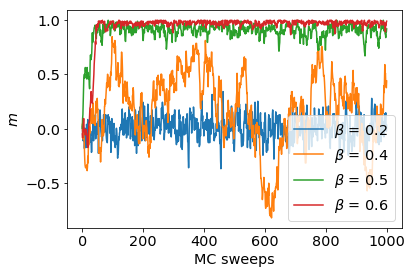

In [5]:
random_seed = 1
np.random.seed(random_seed)
sweep_time = 1000
energies_20, average_spins_20, configurations_20 = metropolis_mc_fast(n_sweeps=sweep_time,  \
                                                                lattice_dimension=15, beta=0.2, J=1, h=0)
energies_40, average_spins_40, configurations_40 = metropolis_mc_fast(n_sweeps=sweep_time,  \
                                                                lattice_dimension=15, beta=0.4, J=1, h=0)
energies_50, average_spins_50, configurations_50 = metropolis_mc_fast(n_sweeps=sweep_time,  \
                                                                lattice_dimension=15, beta=0.5, J=1, h=0)
energies_60, average_spins_60, configurations_60 = metropolis_mc_fast(n_sweeps=sweep_time,  \
                                                                lattice_dimension=15, beta=0.6, J=1, h=0)

x_times = np.linspace(0,sweep_time,sweep_time)
plt.plot(x_times, average_spins_20, label=r'$\beta$ = 0.2')
plt.plot(x_times, average_spins_40, label=r'$\beta$ = 0.4')
plt.plot(x_times, average_spins_50, label=r'$\beta$ = 0.5')
plt.plot(x_times, average_spins_60, label=r'$\beta$ = 0.6')
plt.legend(loc='best')
plt.xlabel('MC sweeps')
plt.ylabel(r'$ m  $')
plt.savefig('Ising_temps')


You need to run longer as you approach transition temperature because the entropic cost of defects and the energetic benefit of pairing are close, resulting in large fluctuations in magnetization, which means that more simulation time is needed to converge the average. Farther away from the transition temperature, either order or disorder dominates, and the averages converge relatively quickly. 

<IPython.core.display.Javascript object>


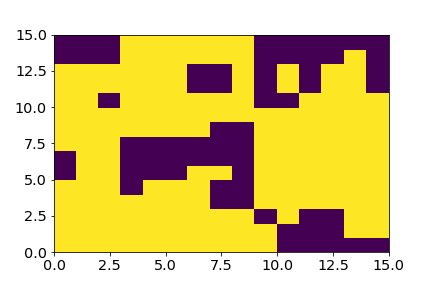

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib notebook
%matplotlib notebook

fig2 = plt.figure()

ims = []
for conf in configurations_40:
    ims.append((plt.pcolor(conf),))

im_ani = animation.ArtistAnimation(fig2, ims, interval=50, repeat_delay=3000,
                                   blit=True)

plt.show()


# Part 2 - Critical Exponents in the Zero-Field 2D Ising Model

As you learned in class, phase transitions can be described by various [critical exponents](https://en.wikipedia.org/wiki/Critical_exponent) for observables like the average magnetization, magentic susceptibility, and heat capacity. These critical exponents have been studied specifically for [Ising models](https://en.wikipedia.org/wiki/Ising_critical_exponents)---we will investigate these exponents in this part of the module. Make sure you read both of these links and consult your notes, as they will be useful for this section.

Run 5 simulations ($J=1, h=0$) for each $\beta$ value in a range that goes from above to below the critical temperature. The $\beta$ range is up to you, but you want data both near the transition temperature and in the regime where either the ordered or disorded phase dominates. A reasonable choice is ten $\beta$ values between 0.2 and 0.6, but you are encouraged to explore alternatives. You may want to gather some preliminary data, and then go back and edit your range to more clearly define the regions/slopes of interest. Use these data to answer the following questions:

1) From your simulations, find the average absolute magnetization (average spin in the lattice, $|m|$---the absolute value is taken to control for the symmetry between all $-1$ spins and all 1 spins) for your chosen $\beta$ range. Graph this (and the associated standard deviations as error bars---check `plt.errorbar()` ) for both a $15\times 15$ and a $20\times 20$ lattice. Also graph this in terms of the reduced temperature $\epsilon = (T - T_C)/T_C$. Briefly explain the trends you see in these graphs.

2) Plot the net magnetization against reduced temperature on a log-log plot in order to extract the critical exponent from the slope. You will have to limit the data points to those  in the ordered regime---check the definition of this critical exponent $\beta$ (not to be confused with the inverse temperature). What values of the critical exponent do you obtain? How does it compare to the analytical result of $\beta$ = 0.125? `np.polyfit()` might be useful here. Comment on the size and direction of the error due to finite size effects.

3) Repeat this procedure for both the per spin magnetic susceptibility and heat capacity, obtaining the critical exponents $\gamma$ and $\alpha$, respectively. It may take a bit of thinking, but you should be able to get this information from your simulations, assuming you output the energies and magnetizations of your simulations for every Monte Carlo sweep. *Hint*: How are these quantities related to energy and magnetization fluctuations? Also note that for the critical exponent step, now you have to limit the data points to those in the disordered regime.

*Note:* Remember that you are starting your simulation out of equilibrium, in a random initialization. Thus, when calculating averages, you will want to discard some of the sampling from each trajectory and use only the equilibrium part of the sampling. Furthermore, feel free to graph the heat capacity $C_V$ in units of $k_B$, which will make it so you don't have to choose a particular unit system. If you are not satisfied with the critical exponents you obtain by using this method, feel free to also try the size rescaling approach found in Section 2.4 of [this paper](https://arxiv.org/pdf/0803.0217.pdf). In this approach, you find the critical exponents by varying the size of the Ising model itself. 

In [4]:
def run_5sims(beta_t, n_iter, lat_dim):
    e_mean = 0
    s_mean = 0
    e_var = 0
    s_var = 0
    c_v = 0
    x_t = 0
    
    spins = np.zeros(n_iter)
    svars = np.zeros(n_iter)
    cvs = np.zeros(n_iter)
    xts = np.zeros(n_iter)
    for i in range(n_iter):
        e1, s1, c1 = metropolis_mc_fast(n_sweeps=1000,lattice_dimension=lat_dim, beta=beta_t, J=1, h=0)
        e_mean = np.asarray(e1[200:]).mean()
        e_var = np.asarray(e1[200:]).var()
        s_mean = np.abs(np.asarray(s1[200:])).mean()
        s_var = np.abs(np.asarray(s1[200:])).var()
        c_v = (beta_t**2) * e_var / (lat_dim**2)
        x_t = beta_t * s_var
        
        spins[i] = s_mean
        svars[i] = s_var
        cvs[i] = c_v
        xts[i] = x_t
     
        #print("Done one sim!")
    return spins, svars, cvs, xts        

In [ ]:
betas = [0.2, 0.3, 0.35, 0.40, 0.42, 0.46, 0.48, 0.53, 0.6, 0.7]
# avg_m = []
# var_m = []
# avg_cv = []
# avg_xt = []
# for beta_t in betas:
#     s_b, sv_b, cv_b, xt_b = run_5sims(beta_t, 5, 15)
#     avg_m.append(s_b.mean())
#     var_m.append(sv_b.mean() + s_b.var())
#     avg_cv.append(cv_b.mean())
#     avg_xt.append(xt_b.mean())
#     print('Finished one temperature')
    
avg_m20 = []
var_m20 = []
avg_cv20 = []
avg_xt20 = []
for beta_t in betas:
    s_b, sv_b, cv_b, xt_b = run_5sims(beta_t, 10, 20)
    avg_m20.append(s_b.mean())
    var_m20.append(sv_b.mean() + s_b.var())
    avg_cv20.append(cv_b.mean())
    avg_xt20.append(xt_b.mean())
    print('Finished one temperature')

Finished one temperature
Finished one temperature
Finished one temperature
Finished one temperature
Finished one temperature
Finished one temperature
Finished one temperature
Finished one temperature
Finished one temperature


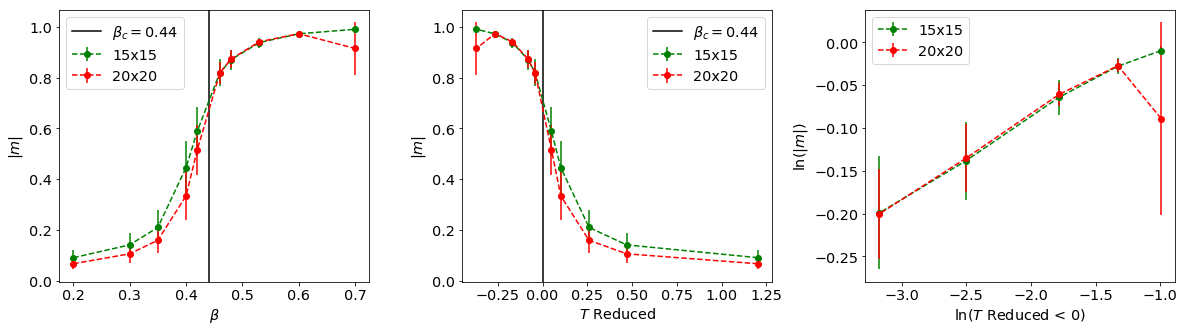

In [15]:
beta_c = 0.44072
red_bc = ((1.0/np.asarray(betas)) - (1.0/beta_c))/(1.0/beta_c)

f, ax = plt.subplots(1,3, figsize = (20,5))
plt.subplots_adjust(wspace=0.3)
ax[0].errorbar(betas, avg_m, fmt = 'go--', yerr=((np.asarray(var_m)/5.0)**(1.0/2.0)), label = '15x15')
ax[0].errorbar(betas, avg_m20, fmt = 'ro--', yerr=((np.asarray(var_m20)/5.0)**(1.0/2.0)), label = '20x20' )
ax[0].set_ylabel(r'$ |m|  $')
ax[0].set_xlabel(r'$\beta$')
ax[0].axvline(x=0.44, color='k', linestyle='-', label = r'$\beta_c = 0.44$')
ax[0].legend(loc='upper left')

ax[1].errorbar(red_bc, avg_m, fmt = 'go--', yerr=((np.asarray(var_m)/5.0)**(1.0/2.0)), label = '15x15')
ax[1].errorbar(red_bc, avg_m20, fmt = 'ro--', yerr=((np.asarray(var_m20)/5.0)**(1.0/2.0)), label = '20x20' )
ax[1].set_ylabel(r'$ |m|  $')
ax[1].set_xlabel(r'$T$ Reduced')
ax[1].axvline(x=0.0, color='k', linestyle='-', label = r'$\beta_c = 0.44$')
ax[1].legend(loc='upper right')

ax[2].errorbar(np.log(-(red_bc[-1:-6:-1])), np.log(np.asarray(avg_m[-1:-6:-1])), fmt = 'go--', yerr=((np.asarray(var_m[-1:-6:-1])/5.0)**(1.0/2.0))/np.asarray(avg_m[-1:-6:-1]), label = '15x15')
ax[2].errorbar(np.log(-(red_bc[-1:-6:-1])), np.log(np.asarray(avg_m20[-1:-6:-1])), fmt = 'ro--', yerr=((np.asarray(var_m20[-1:-6:-1])/5.0)**(1.0/2.0))/np.asarray(avg_m20[-1:-6:-1]), label = '20x20')
ax[2].set_ylabel(r'ln($ |m|  $)')
ax[2].set_xlabel(r'ln($T$ Reduced < 0)')
#ax[2].axvline(x=0.0, color='k', linestyle='-', label = r'$\beta_c = 0.44$')
ax[2].legend(loc='upper left')
plt.show()


In [7]:
fits = np.polyfit(np.log(-(red_bc[-1:-6:-1])), np.log(np.asarray(avg_m[-1:-6:-1])), 1)
print(fits)
fits = np.polyfit(np.log(-(red_bc[-1:-6:-1])), np.log(np.asarray(avg_m20[-1:-6:-1])), 1)
print(fits)


[0.08953267 0.08718696]
[0.07085075 0.04455435]


Trend-wise, as temperature increases, the average magnetization decreases, which is as expected. As temperature increases, entropic effects tend to dominate the energetic benefit of pairing. Therefore, one would expect a lack of spontaneous magnetization at high temperatures in the absence of a magnetic field. 

The expected value of the critical exponent is $\beta$ = 0.125. Our values of around 0.09 underestimate this value, for both the 15x15 and the 20x20 lattice. This could be due to a variety of reasons, including random error. However, the most likely source of error is due to finite size effects. Our simulations are for relatively small lattices, and phase transitions only happen in the thermodynamic limit. It is known that mean field approaches to the Ising model over-approximate this $\beta$, as you are averaging out all of the fluctuations in the system. In contrast, finite size effects here lead to the opposite phenomenon - if there is a random fluctuation on the border of the lattice, its effect is propagated throughout the lattice due to PBCs. Because of the small size of the lattice, this effect is relatively large. This artificially increases the fluctuations, which would "smooth out" the transition region near the critical temperature, leading to an underestimate of the critical exponent. 

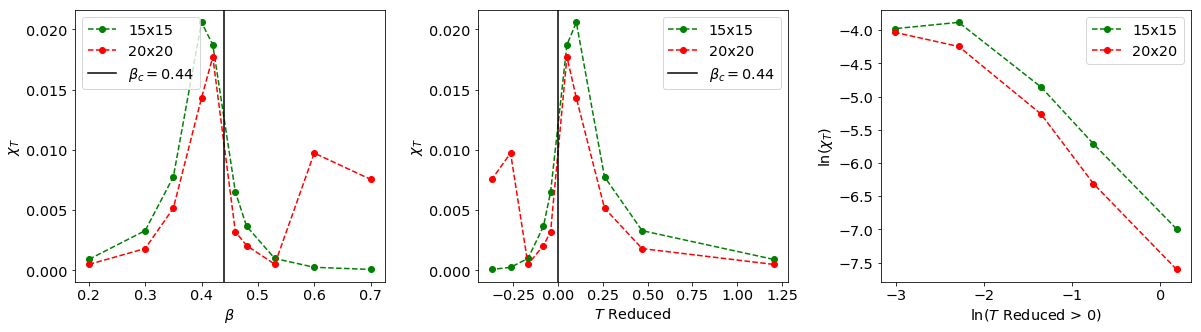

In [8]:
f, ax = plt.subplots(1,3, figsize = (20,5))
plt.subplots_adjust(wspace=0.3)
ax[0].plot(betas, avg_xt, 'go--', label = '15x15')
ax[0].plot(betas, avg_xt20, 'ro--', label = '20x20' )
ax[0].set_ylabel(r'$\chi_T$')
ax[0].set_xlabel(r'$\beta$')
ax[0].axvline(x=0.44, color='k', linestyle='-', label = r'$\beta_c = 0.44$')
ax[0].legend(loc='upper left')

ax[1].plot(red_bc, avg_xt, 'go--', label = '15x15')
ax[1].plot(red_bc, avg_xt20, 'ro--', label = '20x20' )
ax[1].set_ylabel(r'$\chi_T$')
ax[1].set_xlabel(r'$T$ Reduced')
ax[1].axvline(x=0.0, color='k', linestyle='-', label = r'$\beta_c = 0.44$')
ax[1].legend(loc='upper right')

ax[2].plot(np.log((red_bc[0:5])), np.log(np.asarray(avg_xt[0:5])), 'go--', label = '15x15')
ax[2].plot(np.log((red_bc[0:5])), np.log(np.asarray(avg_xt20[0:5])), 'ro--', label = '20x20')
ax[2].set_ylabel(r'ln($\chi_T$)')
ax[2].set_xlabel(r'ln($T$ Reduced > 0)')
#ax[2].axvline(x=0.0, color='k', linestyle='-', label = r'$\beta_c = 0.44$')
ax[2].legend(loc='upper right')
plt.show()

In [9]:
fits = np.polyfit(np.log((red_bc[0:5])), np.log(np.asarray(avg_xt[0:5])), 1)
print(-fits)
fits = np.polyfit(np.log((red_bc[0:5])), np.log(np.asarray(avg_xt20[0:5])), 1)
print(-fits)

[0.99565467 6.52207837]
[1.16250126 7.17001281]


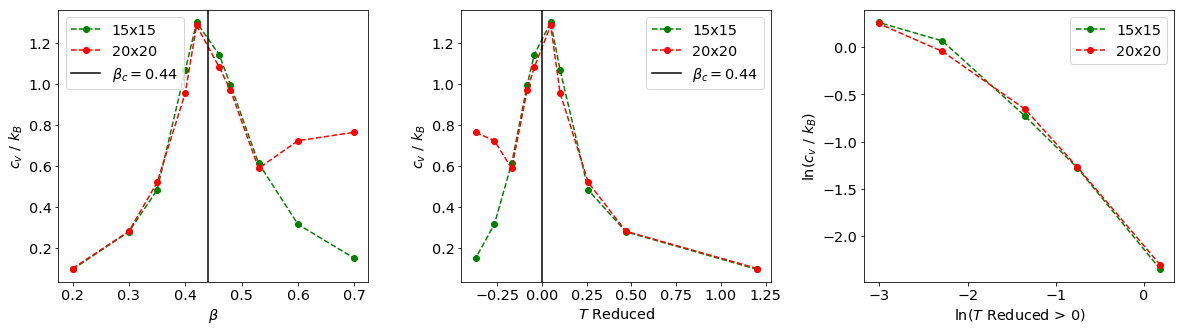

In [10]:
f, ax = plt.subplots(1,3, figsize = (20,5))
plt.subplots_adjust(wspace=0.3)
ax[0].plot(betas, avg_cv, 'go--', label = '15x15')
ax[0].plot(betas, avg_cv20, 'ro--', label = '20x20' )
ax[0].set_ylabel(r'$c_v$ / $k_B$')
ax[0].set_xlabel(r'$\beta$')
ax[0].axvline(x=0.44, color='k', linestyle='-', label = r'$\beta_c = 0.44$')
ax[0].legend(loc='upper left')

ax[1].plot(red_bc, avg_cv, 'go--', label = '15x15')
ax[1].plot(red_bc, avg_cv20, 'ro--', label = '20x20' )
ax[1].set_ylabel(r'$c_v$ / $k_B$')
ax[1].set_xlabel(r'$T$ Reduced')
ax[1].axvline(x=0.0, color='k', linestyle='-', label = r'$\beta_c = 0.44$')
ax[1].legend(loc='upper right')


ax[2].plot(np.log((red_bc[0:5])), np.log(np.asarray(avg_cv[0:5])), 'go--', label = '15x15')
ax[2].plot(np.log((red_bc[0:5])), np.log(np.asarray(avg_cv20[0:5])), 'ro--', label = '20x20')
ax[2].set_ylabel(r'ln($c_v$ / $k_B$)')
ax[2].set_xlabel(r'ln($T$ Reduced > 0)')
#ax[2].axvline(x=0.0, color='k', linestyle='-', label = r'$\beta_c = 0.44$')
ax[2].legend(loc='upper right')
plt.show()

In [11]:
fits = np.polyfit(np.log((red_bc[0:4])), np.log(np.asarray(avg_cv[0:4])), 1)
print(-fits)
fits = np.polyfit(np.log((red_bc[0:4])), np.log(np.asarray(avg_cv20[0:4])), 1)
print(-fits)

[0.97609275 2.10047378]
[0.92227693 2.03991562]


As seen in the graphs, both the magnetic susceptibility and the heat capacity reach a maximum near the critical temperature. This again is as expected - heat capacities and susceptibilities diverge at phase transitions. Fluctuations become arbitrarily large as the system's correlation length diverges, leading to a divergence in these quantities as well. 

These critical exponents aren't particularly close to their analytic values, especially the one for $C_V$. Again, that's OK, as this system is really very small - phase transitions only occur in the thermodynamic limit, and so one would expect the critical exponents to converge only as system size grows. Again, here we are likely over-representing the fluctuations in the system. You can try simulating a much larger system to see if your estimate converges, or try the approach mentioned in the question prompt. 

# Part 3 - Studying the finite-field Ising model using Umbrella Sampling

As you (probably) learned last quarter, Umbrella Sampling (US) can be used  to compute the potential of mean force (PMF, if unfamiliar, read Chandler's *Introduction to Modern Statistical Mechanics* pg. 169-175) efficiently. In this case, we want to compute the probability of seeing a particular value of $m$, including rare values of $m$, at a particular $J$ and $h$. For now, let's look at $\beta = 0.2, h = 0.9$ on a $20\times 20$ lattice. 

We will be implementing a "hard wall" version of US. Specifically, this means that we will run a range of simulations that are restricted to only sample a certain area of parameter space, in this case magnetization $m$. A common alternative is to introduce harmonic biasing functions, which results in faster suppression of window boundary effects.

For each simulation, you will generate a starting configuration within the allowed "window," $m_i \pm \delta$, and then evolve the system as normal. The only difference from what we did before is that now any proposed configuration outside of $m_i \pm \delta$ has an infinite energy. As a result, copies of the system can be forced to sample high-energy, low-probability areas of parameter space. We can then combine all of the data, account for the biases introduced, and stitch the results together to obtain the unbiased PMF. For the hard wall US, accounting for the applied biases simply means making sure the PMF is continuous.
More general and sophisticated schemes for combining the data exist: the Weighted Histogram Analysis Method ([WHAM](http://www.alchemistry.org/wiki/Weighted_Histogram_Analysis_Method)) and the Eigenvector Method for Umbrella Sampling ([EMUS](https://aip.scitation.org/doi/10.1063/1.4960649)), as examples.

For now, modify your Ising model from above to run this type of US simulation, controlling the sampling of the magnetization $m$ (no absolute value). You should first make sure you can generate an initial configuration inside your desired window of $m$ to be simulated, and then evolve the system using the Metropolis criterion,  rejecting any moves that take the configuration outside of $m_i \pm \delta$. A reasonable starting point is to use 7 windows between $m=0.2$ and $m=0.8$ (using $\delta = 0.05$), but you can vary this to try to improve the sampling. For each window, run at least 5 simulations of 500 sweeps each, saving the magnetization trajectories from each. From there, histogram your magnetizations in each window, and convert those histogram counts into a PMF. Stitch together your PMF to make it continuous, and shift the minimum to 0. 

1) Graph both your PMF and your associated normalized probability to show the free energy and probability associated with a range of magnetization values when $\beta = 0.2, h = 0.9$. What is the most likely magnetization value for this set of parameters? Why is this the case? How do you think your answer would change as you increased $h$? As you increased temperature? You are encouranged to perform simulations for these other conditions, but it is not required for the assignment.     

2) Do the same thing, but now with $\beta = 0.5, h=0.01$. Rationalize what you see. What would happen if you tried to make a similar PMF graph, but without having any biasing potentials---i.e., just running at equilibrium? 

*Note:* `np.histogram` will prove useful for this part of the module. You also will likely end up having many bins with counts = 0, which can prove tricky when taking a logarithm to find the PMF. In this case, `np.nonzero` might also be useful. 


In [1]:
def init_window(target, delta, lattice_dimension):
    #Initialize an array of -1 spins
    configuration = np.full((lattice_dimension, lattice_dimension), -1)
    #Determine (from m) the number of positive spins needed to reach the target
    n_plus = int(np.round_(lattice_dimension**2 * ((target + 1.0)/2.0)))
    current_plus = 0
    while current_plus < n_plus:
        spin_to_change_x = np.random.randint(lattice_dimension)
        spin_to_change_y = np.random.randint(lattice_dimension)
        if configuration[spin_to_change_x, spin_to_change_y] == -1:
            configuration[spin_to_change_x, spin_to_change_y] = 1
            current_plus += 1
        else:
            pass
        
    return configuration, configuration.mean()


In [37]:
def metropolis_mc_fast_umbrella(n_sweeps, lattice_dimension, beta, J, h, m_i, delta):
    configuration, mi_old = init_window(m_i, delta, lattice_dimension)
    average_spins = []
    energies = []
    configurations = []
    
    n_lattice_sites = lattice_dimension**2
    n_steps = n_sweeps*n_lattice_sites
    
    current_energy = energy_ising_2d(configuration,J,h)
    
    for step_i in range(n_steps):
        if(step_i%n_lattice_sites==0):
            average_spin = configuration.mean()
            average_spins.append(average_spin)
            energies.append(current_energy)
            configurations.append(np.copy(configuration))

        
        spin_to_change_x = np.random.randint(lattice_dimension)
        spin_to_change_y = np.random.randint(lattice_dimension)
        
        spin_value = configuration[spin_to_change_x, spin_to_change_y]
        spin_value_up = configuration[spin_to_change_x, (spin_to_change_y + 1) % lattice_dimension]
        spin_value_down = configuration[spin_to_change_x, (spin_to_change_y - 1) % lattice_dimension]
        spin_value_left = configuration[(spin_to_change_x - 1) % lattice_dimension, spin_to_change_y]
        spin_value_right = configuration[(spin_to_change_x + 1) % lattice_dimension, spin_to_change_y]
        
        mi_new = mi_old - (2.0*float(spin_value)/ float(n_lattice_sites))
        dE = energy_difference(J, h, spin_value, spin_value_up, spin_value_down, spin_value_left, spin_value_right)
        r = np.random.random()
        # fill in the metropolis critereon, using dE
        
        if np.abs(mi_new - m_i) <= delta:
            if dE < 0:
                #flip the spin
                configuration[spin_to_change_x, spin_to_change_y]*=-1
                # update the energy
                current_energy += dE
                #update the magnetization
                mi_old = mi_new
        
            elif r<np.exp(-beta*dE):
                #flip the spin
                configuration[spin_to_change_x, spin_to_change_y]*=-1
                # update the energy
                current_energy += dE
                #update the magnetization
                mi_old = mi_new
                
            else:
                pass
            
        else:
            pass
    
    return energies, average_spins, configurations

In [41]:
delta = 0.05
m_i_list = np.arange(0.2,0.8+delta*2,delta*2)
h_val = 0.9
beta = 0.2
n_copies = 5
lattice_dimension = 20

all_average_spins = []
for m_i in m_i_list:
    average_spins_m_i = []
    for j in range(n_copies):
        energies, average_spins, configurations = metropolis_mc_fast_umbrella(500, lattice_dimension, beta=beta, \
                                                                              J=1, h=h_val, m_i=m_i, delta=delta)
        average_spins_m_i.extend(average_spins[100:])
        #average_spins_m_i.extend(average_spins)

    all_average_spins.append(average_spins_m_i)


Text(0, 0.5, '$P_i(m)$')

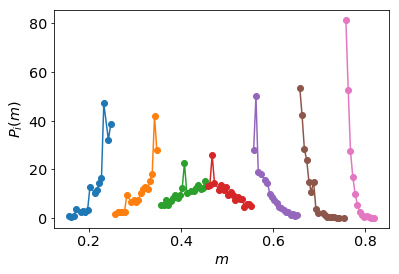

In [42]:
def bin_centers(bins):
    return (bins[:-1]+bins[1:])/2.0

all_bins = np.arange(0,1,delta/10.)
pmf_list = []
bin_centers_list = []
for average_spins in all_average_spins:
    hist,bins = np.histogram(average_spins,bins=all_bins,density=True)
    select = np.nonzero(hist)
    pmf = -np.log(hist[select])/beta    
    pmf_list.append( pmf )
    bin_centers_list.append( bin_centers(all_bins)[select] )
    plt.plot(bin_centers(all_bins)[select],hist[select],marker='o')
plt.xlabel('$m$')
plt.ylabel('$P_i(m)$')

Text(0.5, 0, '$m$')

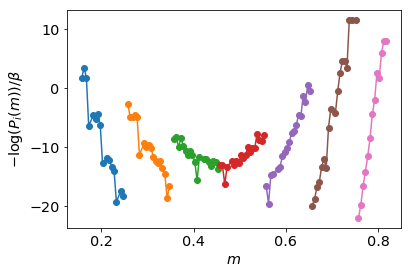

In [43]:
for i in range(len(pmf_list)):
    plot(bin_centers_list[i],pmf_list[i],marker='o')
plt.ylabel('$-\log(P_i(m))/\\beta$')
plt.xlabel('$m$')

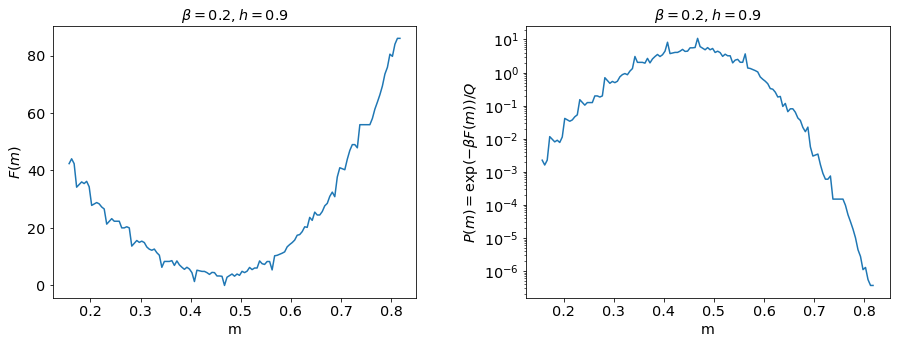

In [44]:
last_bin = pmf_list[0][-1]
stitched = pmf_list[0]
stitched_bins = bin_centers_list[0]
for i in range(1,len(pmf_list)):
    diff = pmf_list[i][0] - last_bin
    new_bit = pmf_list[i] - diff
    stitched = np.append(stitched,new_bit)
    stitched_bins = np.append(stitched_bins, bin_centers_list[i])
    last_bin = stitched[-1]

f, ax = plt.subplots(1,2, figsize = (15,5))
plt.subplots_adjust(wspace=0.3)
shift_PMF = stitched - stitched.min()
ax[0].plot(stitched_bins, shift_PMF)
ax[0].set_xlabel('m')
ax[0].set_ylabel(r'$F(m)$')
ax[0].set_title(r'$\beta = 0.2, h = 0.9$')

transf = exp(shift_PMF*-beta)
area = np.trapz(transf, x=stitched_bins)

ax[1].plot(stitched_bins, transf/area)
ax[1].set_xlabel('m')
ax[1].set_ylabel(r'$P(m) = \exp(-\beta F(m)) / Q $')
ax[1].set_title(r'$\beta = 0.2, h = 0.9$')
ax[1].set_yscale('log')


From this, you can see that $m \approx 0.5$ is the most probable magnetization, as this balances the energetic benefit of pairing spins (both with each other and with the external field) with the entropic cost associated with that pairing. As temperature increases, the entropic cost of pairing would increase, shifting the most probable $m$ lower. In contrast, as h increases, the energetic benefit of pairing increases, shifting $m$ higher. The applied magnetic field, in this case, washes out the energetic benefit of pairing when antialigned - if you extend the range of $m$ to vary from 1 to -1, what you see would be very close to a simple harmonic. The next exercise shows you that at smaller applied magnetic fields, you do see the double well potential that you might expect in a very near-symmetric regime. 

## Similar thing - but now showing the double well structure for $T<T_c$


In [45]:
delta = 0.05
m_i_list = np.arange(-0.95,0.95+delta*2,delta*2)
h_val = 0.01
beta = 0.5
n_copies = 10
lattice_dimension = 20

all_average_spins = []
for m_i in m_i_list:
    print('Starting bin centered at ' + str(m_i))
    average_spins_m_i = []
    for j in range(n_copies):
        energies, average_spins, configurations = metropolis_mc_fast_umbrella(500, lattice_dimension, beta=beta, \
                                                                              J=1, h=h_val, m_i=m_i, delta=delta)
        average_spins_m_i.extend(average_spins[100:])
        #average_spins_m_i.extend(average_spins)

    all_average_spins.append(average_spins_m_i)


Starting bin centered at -0.95
Starting bin centered at -0.85
Starting bin centered at -0.75
Starting bin centered at -0.65
Starting bin centered at -0.55
Starting bin centered at -0.45000000000000007
Starting bin centered at -0.3500000000000001
Starting bin centered at -0.2500000000000001
Starting bin centered at -0.15000000000000013
Starting bin centered at -0.050000000000000155
Starting bin centered at 0.04999999999999982
Starting bin centered at 0.1499999999999997
Starting bin centered at 0.24999999999999978
Starting bin centered at 0.34999999999999987
Starting bin centered at 0.44999999999999973
Starting bin centered at 0.5499999999999996
Starting bin centered at 0.6499999999999997
Starting bin centered at 0.7499999999999998
Starting bin centered at 0.8499999999999996
Starting bin centered at 0.9499999999999995


Text(0, 0.5, '$P_i(m)$')

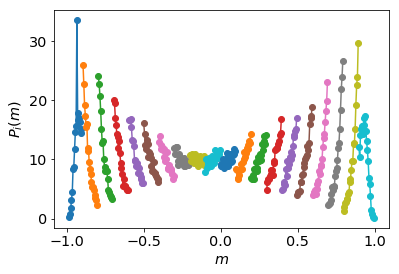

In [46]:
def bin_centers(bins):
    return (bins[:-1]+bins[1:])/2.0

all_bins = np.arange(-1,1 + delta/10.,delta/10.)
pmf_list = []
bin_centers_list = []
for average_spins in all_average_spins:
    hist,bins = np.histogram(average_spins,bins=all_bins,density=True)
    select = np.nonzero(hist)
    pmf = -np.log(hist[select])/beta    
    pmf_list.append( pmf )
    bin_centers_list.append( bin_centers(all_bins)[select] )
    plt.plot(bin_centers(all_bins)[select],hist[select],marker='o')
plt.xlabel('$m$')
plt.ylabel('$P_i(m)$')

Text(0.5, 0, '$m$')

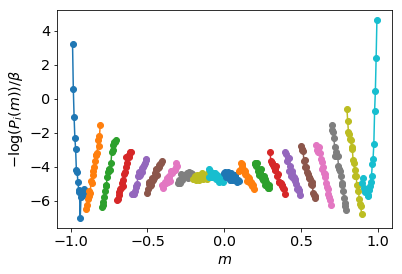

In [47]:
for i in range(len(pmf_list)):
    plot(bin_centers_list[i],pmf_list[i],marker='o')
plt.ylabel('$-\log(P_i(m))/\\beta$')
plt.xlabel('$m$')

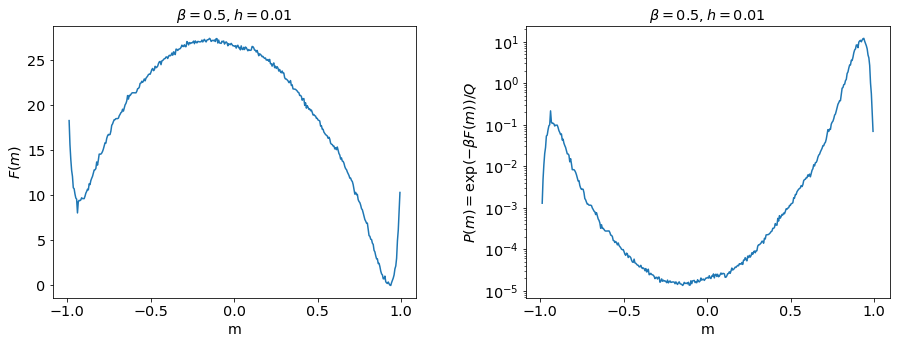

In [48]:
last_bin = pmf_list[0][-1]
stitched = pmf_list[0]
stitched_bins = bin_centers_list[0]
for i in range(1,len(pmf_list)):
    diff = pmf_list[i][0] - last_bin
    new_bit = pmf_list[i] - diff
    stitched = np.append(stitched,new_bit)
    stitched_bins = np.append(stitched_bins, bin_centers_list[i])
    last_bin = stitched[-1]

f, ax = plt.subplots(1,2, figsize = (15,5))
plt.subplots_adjust(wspace=0.3)
shift_PMF = stitched - stitched.min()
ax[0].plot(stitched_bins, shift_PMF)
ax[0].set_xlabel('m')
ax[0].set_ylabel(r'$F(m)$')
ax[0].set_title(r'$\beta = 0.5, h = 0.01$')

transf = exp(shift_PMF*-beta)
area = np.trapz(transf, x=stitched_bins)

ax[1].plot(stitched_bins, transf/area)
ax[1].set_xlabel('m')
ax[1].set_ylabel(r'$P(m) = \exp(-\beta F(m)) / Q $')
ax[1].set_title(r'$\beta = 0.5, h = 0.01$')
ax[1].set_yscale('log')

What's seen here is a double well potential, where there are energetically stable (or metastable) states associated with ordered regimes. The ordered state with the spins aligned with the magnetic field (the right well) is more energetically favorable, but the antialigned, ordered state also exists within a free energy basin. Therefore, one could imagine strange behaviors if this type of simulation was run without biasing potentials. Depending on the initialization, one could imagine a simulation falling into one of the energetic basins and getting "stuck" there. For low enough temperatures, thermal fluctuations would not be sufficient to excite a transition between basins. The mapping of the free energy would thus be incomplete, as one of the energetic basins would remain unexplored. Indeed, if the system initially entered the antialigned state, one might never actually reach the global energetic minimum! This illustrates the advantages of enhanced sampling techniques - by using techniques like US, one can more fully explore parameter space, obtaining sampling in regions that would not normally be explored in equilibrium. By doing this, one increases the probability of, for example, seeing local minima that were "blocked" in the equilibrium simulation due to a free energy barrier. 